In [29]:
import scipy
import scipy.fftpack
import scipy.special
import numpy as nps
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import time
from numpy.fft import rfft, irfft, fft, ifft
import pycoss.rod as rod
import pycoss.rod.interp.FFT as FFT
from pycoss.rod.helpers import *
from pycoss.rod.integrators import *
import pycoss.rod.helpers.plotting as plotting
from pathlib import Path

import sympy
import math

In [30]:
L0 = 1
L = 2
dim = 3

Nm = 200
Mm = 1024
Mm_render = Nm*2
Mm_save = Nm*10

# Generate curve

random_seed = 3323
frame_rot_ampl = 3
N_random_curve_modes = 3
mu_random_curve = 0
sigma_random_curve = 0.3

# System parameters

lmbd = 1
alpha = 1

# Simulation parameters

T = 20
taylor_tol = 1e-2

# Misc

N_save = 100
N_clock = 100
N_integrator_trials = int(1e4)

In [31]:
fft_Nm = Nm//2 + 1

us = FFT.grid(Mm, L0)
us_ext = np.linspace(0, L0, Mm+1, endpoint=True)
du = us[1] - us[0]

us_save = FFT.grid(Mm, L0)
us_save_ext = np.linspace(0, L0, Mm_save+1, endpoint=True)
du_save = us[1] - us[0]

In [32]:
path_handler = FFT.FourierHandler(dim, Nm, Mm, L0)
path_handler_render = FFT.FourierHandler(dim, Nm, Mm_render, L0)

In [33]:
frame_rot_th = np.sin(2*np.pi*path_handler_render.grid/L0) * frame_rot_ampl
frame_rot_phi = np.cos(2*np.pi*path_handler_render.grid/L0) * frame_rot_ampl
frame_rot_psi = np.sin(2*np.pi*path_handler_render.grid/L0) * frame_rot_ampl

In [34]:
def generate_random_periodic_function(dim, us, L, N, mu, sigma):
    fs = np.zeros((3, len(us)))
    dfs = np.zeros((3, len(us)))
    
    for i in range(dim):
        fs[i] += np.random.normal(mu, sigma)/2
        
        for j in range(1, N):
            a, b= np.random.normal(mu, sigma), np.random.normal(mu, sigma)
            
            fs[i] += a * np.cos((2*np.pi/L)*j*us) / (j*np.pi)
            fs[i] += b * np.sin((2*np.pi/L)*j*us) / (j*np.pi)
            
            dfs[i] += -(a * (2*np.pi/L)*j / (j*np.pi)) * np.sin((2*np.pi/L)*j*us)
            dfs[i] += (b * (2*np.pi/L)*j / (j*np.pi)) * np.cos((2*np.pi/L)*j*us)
            
    return fs, dfs

R0_raw, dR0_raw = generate_random_periodic_function(dim, path_handler_render.grid, L0,
                                       N_random_curve_modes, mu_random_curve, sigma_random_curve)

#fig = plt.figure(figsize=(10,10))
#plot_centerline(R0_raw, fig=fig)
#plt.show()

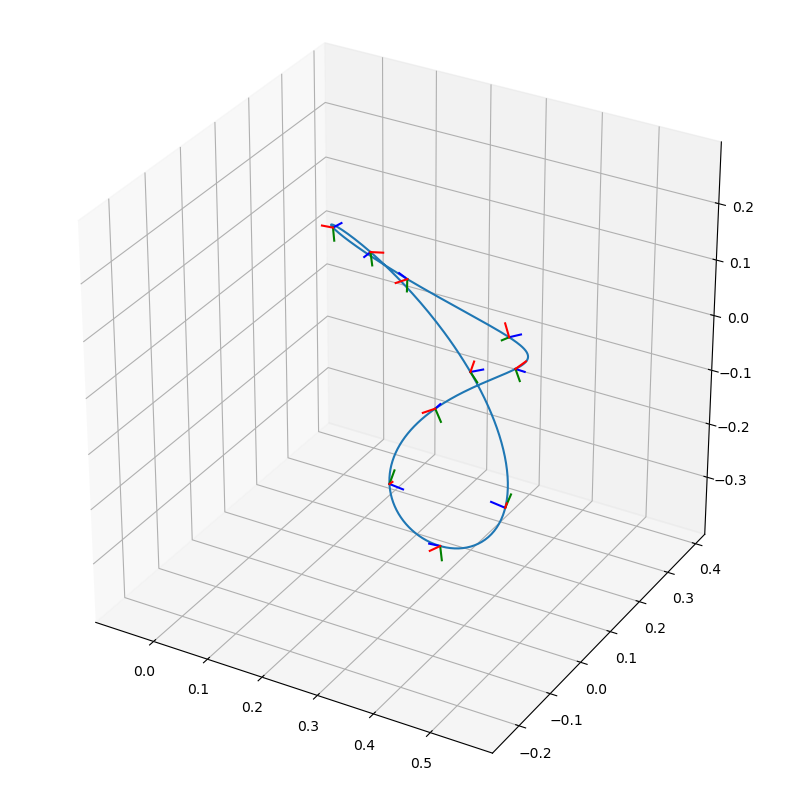

R_err: 0.007194316919445387
close_err: 0.0009064786459531182


In [35]:
c_th0, c_pi0, R_u0, E_u0, R_err0, close_err0 = get_differential_invariants_from_curve(R0_raw, Nm, Mm,
                                                                    L0, L=L, err_tol=1e-1, dR=dR0_raw)

c_th0_render = path_handler.change_Mm(c_th0, Mm, Mm_render)
c_pi0_render = path_handler.change_Mm(c_pi0, Mm, Mm_render)

th0_render = path_handler_render.iDT(c_th0_render)
pi0_render = path_handler_render.iDT(c_pi0_render)

# Rotate the frame

frame_rotation = eul2rot([frame_rot_th, frame_rot_phi, frame_rot_psi])

du_frame_rotation = np.zeros(frame_rotation.shape)
for i in range(3):
    du_frame_rotation[i,:] = path_handler_render.diff_f( frame_rotation[i,:] )
    
pi0_hat_render = hat_vec_to_mat(pi0_render)

transformed_pi0_hat_render = np.einsum('iju,kju->iku', du_frame_rotation, frame_rotation)
transformed_pi0_hat_render += np.einsum('iju,jku,lku->ilu', frame_rotation, pi0_hat_render, frame_rotation)
transformed_pi0_render = hat_mat_to_vec(transformed_pi0_hat_render)

transformed_th0_render = np.einsum('iju,ju->iu', frame_rotation, th0_render)

E_u0 = E_u0.dot(frame_rotation[...,0].T)

th0_render = transformed_th0_render
pi0_render = transformed_pi0_render

# Transform back to Fourier modes

c_th0_render = path_handler_render.DT(th0_render)
c_pi0_render = path_handler_render.DT(pi0_render)

c_th0 = path_handler.change_Mm(c_th0_render, Mm_render, Mm)
c_pi0 = path_handler.change_Mm(c_pi0_render, Mm_render, Mm)

c_th0_render = path_handler.change_Mm(c_th0, Mm, Mm_render)
c_pi0_render = path_handler.change_Mm(c_pi0, Mm, Mm_render)

th0_render = path_handler_render.iDT(c_th0_render)
pi0_render = path_handler_render.iDT(c_pi0_render)

th0 = path_handler.iDT(c_th0)
pi0 = path_handler.iDT(c_pi0)

# Plot rod

Fr0_u0 = construct_oriented_frame(R_u0, E_u0)
Fr0, R0, E0 = reconstruct_frame(th0_render, hat_vec_to_mat(pi0_render), L0, R_u0, E_u0)

fig = plt.figure(figsize=(10,10))
plotting.plot_centerline_and_frame(R0, E0, fig=fig, N_frame=10, frame_scale=0.03)
plt.show()
plt.close()

print('R_err:', R_err0)
print('close_err:', close_err0)

400

(3, 500)

In [15]:
def get_tube(N_circle, radius):
    xs_circle = np.linspace(0, 2*np.pi, N_circle+1)[:-1]

    tube = np.zeros((N_circle, 3, Mm))
    e1, e2, e3 = E[:,0], E[:,1], E[:,2]

    for i in range(N_circle):
        x = xs_circle[i]
        tube[i] = R + (e2*np.cos(x) + e3*np.sin(x))*radius
        
    return tube

def save_tube(tube, fn):
    tube_points = np.concatenate([ t.T for t in tube ])
    tube_points.astype('float32').tofile('%s.dat'% fn)

In [44]:
Mm = R0.shape[-1]

In [45]:
R = R0

In [49]:
Mm

400

In [48]:
R.shape

(3, 400)

In [51]:
E = E0

In [57]:
tube_radius = 0.01

In [58]:
_E = E*tube_radius
e1, e2, e3 = _E[:,0], _E[:,1], _E[:,2]

In [59]:
tube = get_tube(N_circle, tube_radius)
fibres = get_tube(N_fibres, tube_radius)

save_tube(tube, 'tube')
np.swapaxes(fibres, 1, 2).astype('float32').tofile('fibres.dat')

R.T.astype('float32').tofile('R.dat')
e1.T.astype('float32').tofile('e1.dat')
e2.T.astype('float32').tofile('e2.dat')
e3.T.astype('float32').tofile('e3.dat')

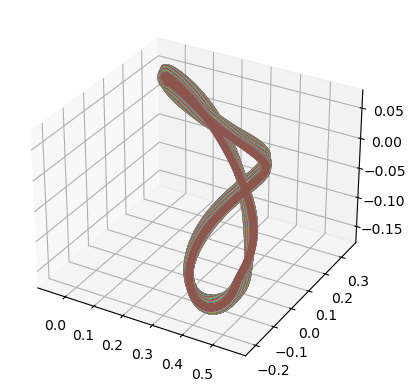

In [60]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(N_circle):
    xs,ys,zs = tube[i]
    ax.scatter(xs,ys,zs)
    
plt.show()

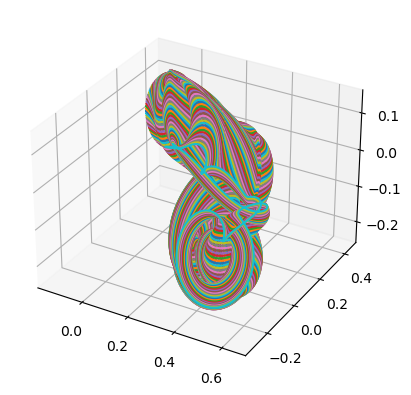

In [55]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(N_circle):
    xs,ys,zs = tube[i]
    ax.plot(xs,ys,zs)
    
plt.show()